In [1]:
import tensorflow as tf

In [2]:
dataset_url = r'2750'
batch_size = 32
img_height = 244
img_width = 244
validation_split=0.2
rescale=1.0/255

In [3]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


2024-05-25 19:39:22.172861: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-25 19:39:22.172889: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-25 19:39:22.172898: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-25 19:39:22.172931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-25 19:39:22.172950: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [5]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


In [6]:
def expansion_block(x , t , filters , block_id):
    total_filters = t*filters
    x = tf.keras.layers.Conv2D(total_filters, 1 , padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6)(x) #uses ReLU 6 
    return x

In [7]:
def depthwise_block(x , stride , block_id):
    x = tf.keras.layers.DepthwiseConv2D(3 , strides = (stride,stride) , padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU(6)(x)
    return x

In [8]:
def projection_block(x,out_channels,block_id):
    x = tf.keras.layers.Conv2D(filters= out_channels , kernel_size= 1 , padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

In [9]:
def bottleneck(x,t,filters, out_channels,stride,block_id):
    y = expansion_block(x,t,filters,block_id)
    y = depthwise_block(y,stride,block_id)
    y = projection_block(y, out_channels,block_id)
    if y.shape[-1]==x.shape[-1]: #Adding skip connection
        y = add([x,y])
    return y

In [10]:
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, ReLU, BatchNormalization, add,Softmax, AveragePooling2D, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [11]:
def MobileNetV2(input_image = (224,224,3), n_classes=10):
    inputs = Input(input_image)

    x = Conv2D(32,kernel_size=3,strides=(2,2),padding = 'same', use_bias=False)(inputs)
    x = BatchNormalization(name='conv1_bn')(x)
    x = ReLU(6, name = 'conv1_relu')(x)

    x = depthwise_block(x,stride=1,block_id=1)
    x = projection_block(x, out_channels=16,block_id=1)

    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 2,block_id = 2)
    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 1,block_id = 3)

    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 2,block_id = 4)
    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 5)
    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 6)

    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 2,block_id = 7)
    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 8)
    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 9)
    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 10)

    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 11)
    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 12)
    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 13)

    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 2,block_id = 14)
    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 15)
    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 16)

    x = bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 320, stride = 1,block_id = 17)


    x = Conv2D(filters = 1280,kernel_size = 1,padding='same',use_bias=False, name = 'last_conv')(x)
    x = BatchNormalization(name='last_bn')(x)
    x = ReLU(6,name='last_relu')(x)

    x = GlobalAveragePooling2D(name='global_average_pool')(x)
    output = Dense(n_classes,activation='softmax')(x)
    model = Model(inputs, output)

    return model

In [12]:
model = MobileNetV2(input_image=(64,64,3), n_classes=10)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=2)
with tf.device("/gpu:0"):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']  )
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=10, batch_size=32 , callbacks = [callback])

Epoch 1/10


2024-05-25 19:39:27.109990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


675/675 [==============================] - 546s 789ms/step - loss: 1.1678 - accuracy: 0.5830 - val_loss: 3.8614 - val_accuracy: 0.2911
Epoch 2/10
675/675 [==============================] - 539s 799ms/step - loss: 1.0407 - accuracy: 0.6333 - val_loss: 4.2172 - val_accuracy: 0.2335
Epoch 3/10
675/675 [==============================] - 600s 889ms/step - loss: 0.9567 - accuracy: 0.6579 - val_loss: 2.7349 - val_accuracy: 0.3972
Epoch 4/10
675/675 [==============================] - 603s 893ms/step - loss: 0.9139 - accuracy: 0.6741 - val_loss: 1.9910 - val_accuracy: 0.4965
Epoch 5/10
675/675 [==============================] - 593s 878ms/step - loss: 0.9080 - accuracy: 0.6793 - val_loss: 1.4873 - val_accuracy: 0.5030
Epoch 6/10
675/675 [==============================] - 592s 876ms/step - loss: 0.9075 - accuracy: 0.6761 - val_loss: 1.8454 - val_accuracy: 0.5319
Epoch 7/10
675/675 [==============================] - 559s 828ms/step - loss: 0.8290 - accuracy: 0.7099 - val_loss: 1.2510 - val_accura

In [13]:
model.save('lulc_5_epoch.h5')

/Users/ankurmishra/anaconda3/envs/bla_bla/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
import matplotlib.pyplot as plt

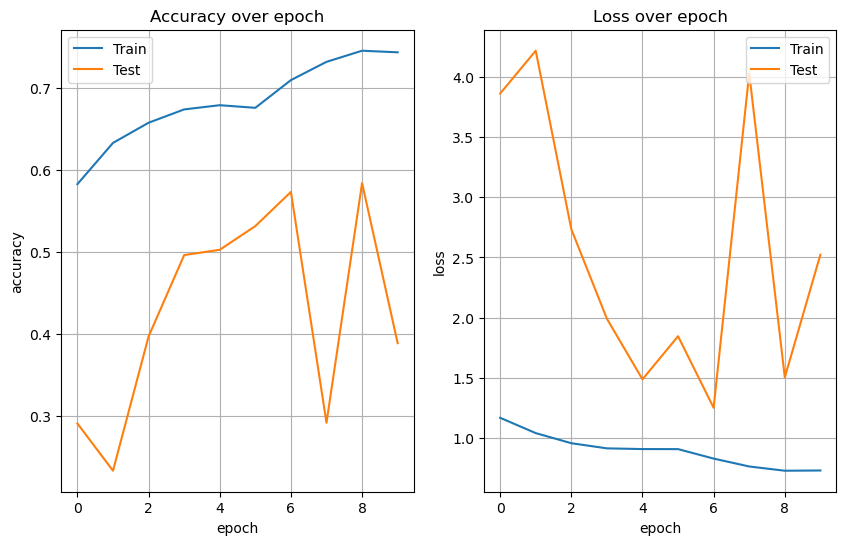

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')
ax1.grid(True)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")
ax2.grid(True)

In [16]:
preds = model.predict(test_dataset)

169/169 [==============================] - 38s 217ms/step
